In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# view the columns in each table within the database
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

most_recent_date = most_recent_date[0].split("-") # split the tuple into a list
most_recent_year = int(most_recent_date[0]) # extract elements from the list as integers
most_recent_month = int(most_recent_date[1])
most_recent_day = int(most_recent_date[2])

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(most_recent_year,most_recent_month,most_recent_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
latest_y_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
latest_y_prcp_df = pd.DataFrame(latest_y_prcp, columns=("date","precipitation"))

# Sort the dataframe by date
latest_y_prcp_df = latest_y_prcp_df.sort_values('date')
latest_y_prcp_df.head(10)

,date,precipitation
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
1875,2016-08-24,1.45
1188,2016-08-24,1.22
1,2016-08-25,0.08
1007,2016-08-25,0.00
1525,2016-08-25,0.06


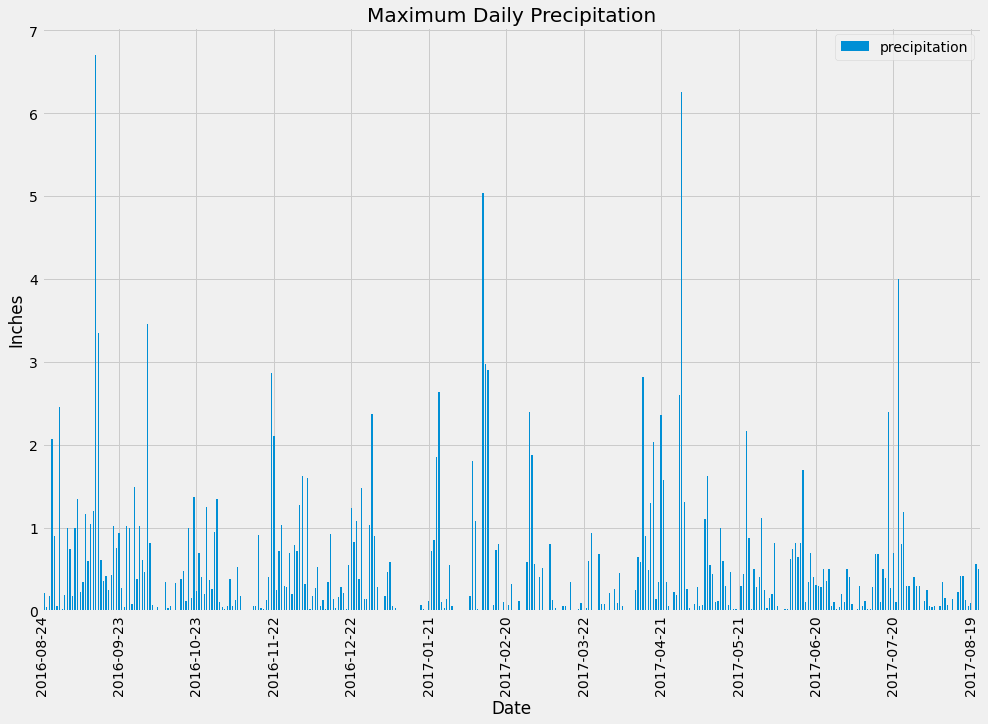

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
daily_pcpt = latest_y_prcp_df.groupby(['date']).max() # max precip recorded per day among all stations
daily_pcpt.plot(kind='bar', figsize = (15,10))
x_axis = np.arange(0,len(daily_pcpt.precipitation))
tick_location = np.arange(0,len(x_axis),int(len(x_axis)/12))
tick_label = [list(latest_y_prcp_df['date'].unique())[x] for x in tick_location]
plt.xticks(tick_location,tick_label,rotation='vertical')
plt.xlabel('Date')
plt.ylabel("Inches")
plt.title("Maximum Daily Precipitation")
plt.xlim(0,max(x_axis))
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = latest_y_prcp_df.groupby(['date']).agg({'precipitation':['min','max','mean','median','var','std','sem']})
summary_stats

precipitation                                                     
                     min   max      mean median       var       std       sem
date                                                                         
2016-08-24          0.08  2.28  1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25          0.00  0.21  0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26          0.00  0.04  0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27          0.00  0.18  0.064000  0.020  0.006680  0.081731  0.036551
2016-08-28          0.01  2.07  0.516667  0.140  0.620427  0.787672  0.321566
...                  ...   ...       ...    ...       ...       ...       ...
2017-08-19          0.00  0.09  0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20          0.00  0.01  0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21          0.00  0.56  0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22          0.00  0.50  0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23          0.00  0.45  0.132500  0.040  0.046225  0.215000  0.107500

[365 rows x 7 columns]

In [22]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.id)).all()
num_stations

[(9)]

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc())
station_activity.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = station_activity.first()[0]

min_temp = session.query(Measurement.station,func.min(Measurement.tobs)).\
                        filter(Measurement.station==most_active_station).all()

max_temp = session.query(Measurement.station,func.max(Measurement.tobs)).\
                        filter(Measurement.station==most_active_station).all()

print(f'The lowest temperature recorded at station: {most_active_station} was {min_temp[0][1]}')
print(f'The highest temperature recorded at station: {most_active_station} was {max_temp[0][1]}')

The lowest temperature recorded at station: USC00519281 was 54.0
The highest temperature recorded at station: USC00519281 was 85.0


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.date,Measurement.station,Measurement.tobs).\
filter(Measurement.station == most_active_station).\
filter(Measurement.date > one_year_ago).all()

[('2016-08-24', 'USC00519281', 77.0),
 ('2016-08-25', 'USC00519281', 80.0),
 ('2016-08-26', 'USC00519281', 80.0),
 ('2016-08-27', 'USC00519281', 75.0),
 ('2016-08-28', 'USC00519281', 73.0),
 ('2016-08-29', 'USC00519281', 78.0),
 ('2016-08-30', 'USC00519281', 77.0),
 ('2016-08-31', 'USC00519281', 78.0),
 ('2016-09-01', 'USC00519281', 80.0),
 ('2016-09-02', 'USC00519281', 80.0),
 ('2016-09-03', 'USC00519281', 78.0),
 ('2016-09-04', 'USC00519281', 78.0),
 ('2016-09-05', 'USC00519281', 78.0),
 ('2016-09-06', 'USC00519281', 73.0),
 ('2016-09-07', 'USC00519281', 74.0),
 ('2016-09-08', 'USC00519281', 80.0),
 ('2016-09-09', 'USC00519281', 79.0),
 ('2016-09-10', 'USC00519281', 77.0),
 ('2016-09-11', 'USC00519281', 80.0),
 ('2016-09-12', 'USC00519281', 76.0),
 ('2016-09-13', 'USC00519281', 79.0),
 ('2016-09-14', 'USC00519281', 75.0),
 ('2016-09-15', 'USC00519281', 79.0),
 ('2016-09-16', 'USC00519281', 78.0),
 ('2016-09-17', 'USC00519281', 79.0),
 ('2016-09-18', 'USC00519281', 78.0),
 ('2016-09-1

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
